In [27]:
%matplotlib inline
%load_ext memory_profiler
from string import ascii_uppercase

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

cols = list(ascii_uppercase[:10])
np.random.seed(42)
data = np.random.randint(1, 100, size=(100_000, 10))
df = pd.DataFrame(data, columns=cols)
df.head()

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


,A,B,C,D,E,F,G,H,I,J
0,52,93,15,72,61,21,83,87,75,75
1,88,24,3,22,53,2,88,30,38,2
2,64,60,21,33,76,58,22,89,49,91
3,59,42,92,60,80,15,62,62,47,62
4,51,55,64,3,51,7,21,73,39,18


In [3]:
%%timeit
df.groupby(['A', 'B'])['C'].count().unstack().fillna(0)

8.61 ms ± 47.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [4]:
%%timeit
df.pivot_table(values='C', index='A', columns='B', aggfunc='count', fill_value=0)

34.5 ms ± 760 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:
%%timeit
pd.crosstab(df.A, df.B)

69.8 ms ± 452 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [160]:
import timeit

from collections import defaultdict
from memory_profiler import memory_usage


def crosstab(df):
    '''Returned count values are integers.'''
    pd.crosstab(df.A, df.B)


def groupby(df):
    '''Returned count values are floats.'''
    df.groupby(['A', 'B'])['C'].count().unstack().fillna(0)


def pivot_table(df):
    '''Returned count values are integers.'''
    df.pivot_table(values='C', index='A', columns='B', aggfunc='count', fill_value=0)


funcs = [crosstab, groupby, pivot_table]
samples = []

for size in np.logspace(0, 6, 7):
#for size in np.logspace(1, 8, 8):
#for size in np.logspace(3, 5, 2):
    size = int(size)
    repetitions = 1
    
    data = np.random.randint(1, 100, size=(size, 10))
    df = pd.DataFrame(data, columns=cols)
    
    for func in funcs:
        duration = timeit.timeit('func(df)', number=repetitions, globals=globals()) / repetitions
        memory = np.mean(memory_usage(proc=(func, (df,))))
        samples.append({'function': func.__name__, 'size': size, 'duration': duration, 'memory': memory})

In [161]:
df_samples = pd.DataFrame(samples)
df_samples['function'] = df_samples.function.astype('category')
df_samples.head()

,duration,function,memory,size
0,0.013879,crosstab,356.342529,10
1,0.002399,groupby,356.343750,10
2,0.013912,pivot_table,356.343750,10
3,0.028353,crosstab,356.343750,100
4,0.002743,groupby,356.343750,100


/home/rg/anaconda3/envs/datamining/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


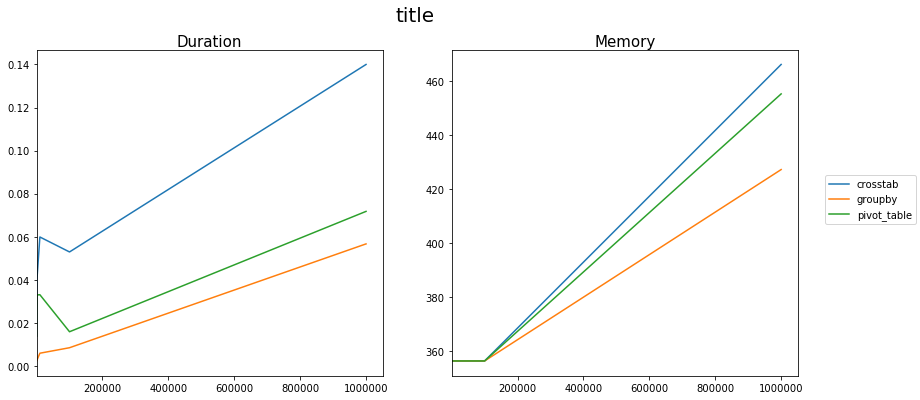

In [163]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False, figsize=(14, 6))

ax_dur = axes[0]
ax_mem = axes[1]

df_dur = df_samples.groupby(['size', 'function']).duration.mean().unstack()
df_mem = df_samples.groupby(['size', 'function']).memory.mean().unstack()

plot_dur = ax_dur.plot(df_dur)
plot_mem = ax_mem.plot(df_mem)

ax_dur.set_title('Duration', fontsize=15, va='top')
#ax_dur.set_xscale('log')
ax_dur.set_xlim(1)
ax_mem.set_title('Memory', fontsize=15, va='top')

fig.suptitle('title', fontsize=20)
fig.legend([plot_dur, plot_mem], labels=df_dur.columns, loc='center right')
plt.subplots_adjust(right=0.88)
#fig.text(0.055, 0.1, info, ha='left', va='center', fontsize=12, color='#444444');

In [155]:

np.logspace(0, 6, 7)

array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])